# Libs

In [1]:
# Работа с данными
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt

# Улучшение модели
from sklearn.model_selection import train_test_split

# Метрики
from sklearn.metrics import f1_score

# Torch
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchsummary import summary

In [3]:
# Остальное
from IPython.display import clear_output
from collections import defaultdict
from PIL import Image
from tqdm import tqdm
import warnings, os, random
from copy import deepcopy

warnings.filterwarnings('ignore')

# Code

## Зафиксируем seed

In [5]:
def set_all_seeds(seed=42):
    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    # torch's seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_all_seeds()

## Полезные функции

In [7]:
def train(model, data_loader, optimizer, loss_fn):
    model = model.cuda()
    model.train()

    total_loss = 0
    
    y_true = list()
    y_pred = list()

    for x, y in tqdm(data_loader):
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        loss.backward()

        total_loss += loss.item()
 
        y_true.extend(y.tolist())
        y_pred.extend(output.argmax(dim=1).tolist())

        optimizer.step()

    return total_loss / len(data_loader), f1_score(y_true, y_pred, average='macro')


@torch.inference_mode()
def evaluate(model, data_loader, loss_fn):
    model = model.cuda()
    model.eval()

    total_loss = 0
    
    y_true = list()
    y_pred = list()

    for x, y in tqdm(data_loader):
        x, y = x.cuda(), y.cuda()
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        y_true.extend(y.tolist())
        y_pred.extend(output.argmax(dim=1).tolist())

    return total_loss / len(data_loader), f1_score(y_true, y_pred, average='macro')

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_f1: list[float],
    valid_f1: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' f1')

    plt.plot(train_f1, label='Train f1')
    plt.plot(valid_f1, label='Valid f1')
    plt.legend()

    plt.show()

In [6]:
def fit(model, train_loader, valid_loader, optimizer, loss_fn, num_epochs, title='Model'):
    train_loss_history, valid_loss_history = [], []
    train_f1_history, valid_f1_history = [], []

    best_valid_f1 = 0.0  # Переменная для отслеживания наилучшей точности
    best_model = None  # Переменная для сохранения модели с наилучшей точностью

    def epoch(count):
        nonlocal best_valid_f1, best_model

        train_loss, train_f1 = train(model, train_loader, optimizer, loss_fn)
        valid_loss, valid_f1 = evaluate(model, valid_loader, loss_fn)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_f1_history.append(train_f1)
        valid_f1_history.append(valid_f1)

        clear_output()

        print(f"Epoch: {count}")
        print(f"F1: {valid_f1:.4f}")

        if valid_f1 > best_valid_f1:
            best_valid_f1 = valid_f1
            best_model = deepcopy(model)  # Сохраняем текущее состояние модели

    epoch(1)

    for i in range(2, num_epochs + 1):
        epoch(i)

        plot_stats(
            train_loss_history, valid_loss_history,
            train_f1_history, valid_f1_history,
            title
        )

    # Возвращаем лучшую модель
    return best_model, best_valid_f1

## Полезные классы

In [7]:
class LinearBlock(nn.Module):
    def __init__(self, input_size, output_size, dropout=0, act_funс=nn.ReLU):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.linear = nn.Linear(input_size, output_size)
        self.act_funс = act_funс()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.linear(x)
        x = self.act_funс(x)
        x = self.dropout(x)
        return x

In [8]:
class Conv2dBlock(nn.Module):
    def __init__(self, input_size, output_size, maxpool2d=True, act_funс=nn.ReLU):
        super().__init__()
        self.batchnorm2d = nn.BatchNorm2d(input_size)
        self.conv2d = nn.Conv2d(in_channels=input_size, out_channels=output_size, kernel_size=3, stride=1, padding=1)
        self.act_funс = act_funс()
        if maxpool2d:
            self.maxpool2d = nn.MaxPool2d(kernel_size=2)
        else:
            self.maxpool2d = None

    def forward(self, x):
        x = self.batchnorm2d(x)
        x = self.conv2d(x)
        x = self.act_funс(x)
        if self.maxpool2d is not None:
            x = self.maxpool2d(x)
        return x

In [9]:
class SkipConnection(nn.Module):
    def __init__(self, *submodule):
        super().__init__()
        self.submodule = nn.Sequential(*submodule)

    def forward(self, x):
        return x + self.submodule(x)  # Простое добавление входа к выходу подмодуля

## Данные

In [10]:
size = (128, 128)

### Преобразование и аугментация

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразовать в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализовать данные
])


augmented_transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Горизонтальное отражение
    transforms.RandomRotation(degrees=10), # Повороты до 10 градусов
    transforms.RandomCrop(size=size, padding=20),  # Случайное обрезание с пустой областью вокруг изображения
    transforms.ColorJitter(brightness=0.2),  # Случайное увеличение яркости на 0.2
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализовать данные
])

augmented_transform2 = transforms.Compose([
    transforms.RandomRotation(degrees=5), # Повороты до 5 градусов
    transforms.RandomCrop(size=size, padding=15),  # Случайное обрезание с пустой областью вокруг изображения
    transforms.ColorJitter(brightness=0.3),  # Случайное увеличение яркости на 0.2
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализовать данные
])

augmented_transform3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),     # Горизонтальное отражение
    transforms.RandomRotation(degrees=15), # Повороты до 15 градусов
    transforms.RandomCrop(size=size, padding=15),  # Случайное обрезание с пустой областью вокруг изображения
    transforms.ColorJitter(brightness=0.2),  # Случайное увеличение яркости на 0.2
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализовать данные
])

### Загрузка

In [12]:
answer = pd.read_csv("train_answers.csv", index_col=0).values.reshape(-1)
classes = ['covid_19', 'non_covid', 'normal']

In [13]:
path = 'train_images'
data = list() # список необработанных данных

for i, image_name in enumerate(tqdm(sorted(os.listdir(path), key=lambda x: int(x[4:-4])))):
    image_numpy = Image.open(f'{path}/{image_name}').resize(size)
    data.append((image_numpy, answer[i]))

random.shuffle(data)

  1%|▏         | 401/27000 [00:00<00:59, 448.58it/s]

100%|██████████| 27000/27000 [00:52<00:00, 518.71it/s]


In [14]:
# Создаем словарь, где ключами будут индексы классов, а значениями списки кортежей данных
class_data = defaultdict(list)
for data_point in data:
    _, class_index = data_point
    class_data[class_index].append(data_point)

trainset = []
testset = []

# Для каждого класса разделяем данные на train и valid
for class_index, data_list in class_data.items():
    train_class, valid_class = train_test_split(data_list, test_size=0.2)
    trainset.extend(train_class)
    testset.extend(valid_class)

random.shuffle(trainset)
random.shuffle(testset)

In [15]:
*trainsets, testset = ( # обработка данных
    [(t(x[0]), x[1]) for x in tqdm(d)]
    for d, t in [
        (trainset, transform),
        (trainset, augmented_transform1),
        (trainset, augmented_transform2),
        (trainset, augmented_transform3),
        (testset, transform),
    ]
)

trainset = trainsets[0] + trainsets[1] + trainsets[2] + trainsets[3]
dataset = trainset + testset

  2%|▏         | 433/21599 [00:00<00:04, 4304.50it/s]

100%|██████████| 5401/5401 [00:00<00:00, 7690.84it/s]


### Создание DataLoader

In [16]:
# Создание DataLoader для каждой выборки
batch_size = 40
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

### Визуализация

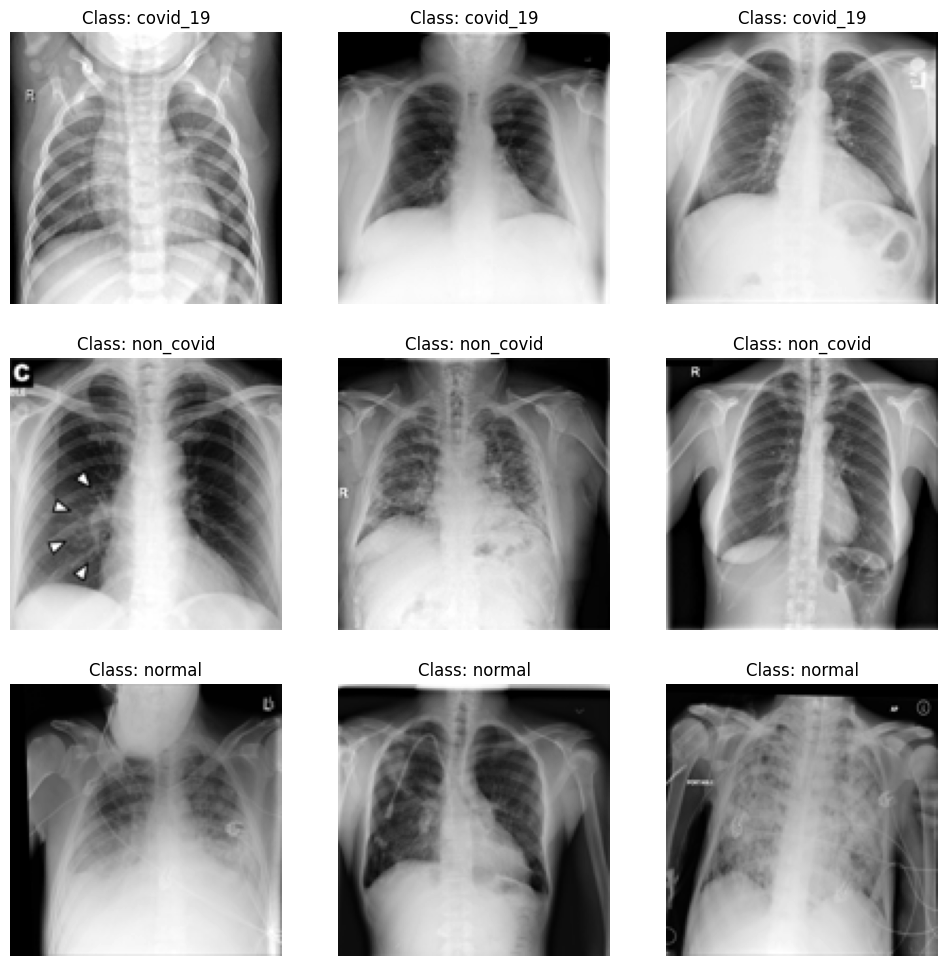

In [17]:
# Создаем список, чтобы отслеживать, сколько элементов каждого класса уже было выведено
elements_per_class = [0] * len(classes)

# Установка размера фигуры
plt.figure(figsize=(12, 12))

# Перебираем классы
for i in range(len(classes)):
    # Счетчик элементов класса в текущей строке
    elements_in_row = 0
    
    # Перебираем элементы датасета
    for j in range(len(dataset)):
        # Проверяем, соответствует ли текущий элемент классу
        if dataset[j][1] == i:
            # Нормализация изображения
            image_tensor = transforms.Normalize((-1), (2))(dataset[j][0])
            
            # Выводим изображение
            plt.subplot(len(classes), 3, i * 3 + elements_in_row + 1)
            plt.imshow(image_tensor[0].numpy(), cmap='gray')
            plt.title(f'Class: {classes[dataset[j][1]]}')
            plt.axis('off')
            
            # Увеличиваем счетчик элементов класса в текущей строке
            elements_per_class[i] += 1
            elements_in_row += 1
            
            # Если выведены уже три элемента, переходим на новую строку
            if elements_in_row == 3:
                break
            
            # Если выведены уже три элемента данного класса, выходим из цикла
            if elements_per_class[i] == 3:
                break

# Показываем график
plt.show()


## Модель

In [21]:
# Сверточная нейронная сеть
model = nn.Sequential(
    Conv2dBlock(1, 9, False),
    Conv2dBlock(9, 16),
    SkipConnection(
        Conv2dBlock(16, 32, False),
        Conv2dBlock(32, 48, False),
        Conv2dBlock(48, 32, False),
        Conv2dBlock(32, 16, False)
    ),
    Conv2dBlock(16, 32, False),
    Conv2dBlock(32, 64),
    SkipConnection(
        Conv2dBlock(64, 64, False)
    ),
    Conv2dBlock(64, 80, False),
    Conv2dBlock(80, 96),
    SkipConnection(
        Conv2dBlock(96, 96, False),
    ),
    Conv2dBlock(96, 112),
    nn.Flatten(),
    LinearBlock(7168, 1000),
    LinearBlock(1000, 500),
    LinearBlock(500, len(classes))
)

### Summary

In [22]:
input_size = (1, *size)
summary(model.cuda(), input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 128, 128]               2
            Conv2d-2          [-1, 9, 128, 128]              90
              ReLU-3          [-1, 9, 128, 128]               0
       Conv2dBlock-4          [-1, 9, 128, 128]               0
       BatchNorm2d-5          [-1, 9, 128, 128]              18
            Conv2d-6         [-1, 16, 128, 128]           1,312
              ReLU-7         [-1, 16, 128, 128]               0
         MaxPool2d-8           [-1, 16, 64, 64]               0
       Conv2dBlock-9           [-1, 16, 64, 64]               0
      BatchNorm2d-10           [-1, 16, 64, 64]              32
           Conv2d-11           [-1, 32, 64, 64]           4,640
             ReLU-12           [-1, 32, 64, 64]               0
      Conv2dBlock-13           [-1, 32, 64, 64]               0
      BatchNorm2d-14           [-1, 32,

## Оптимизатор и функция активации

In [23]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

## Обучение

Epoch: 7
F1: 0.9274


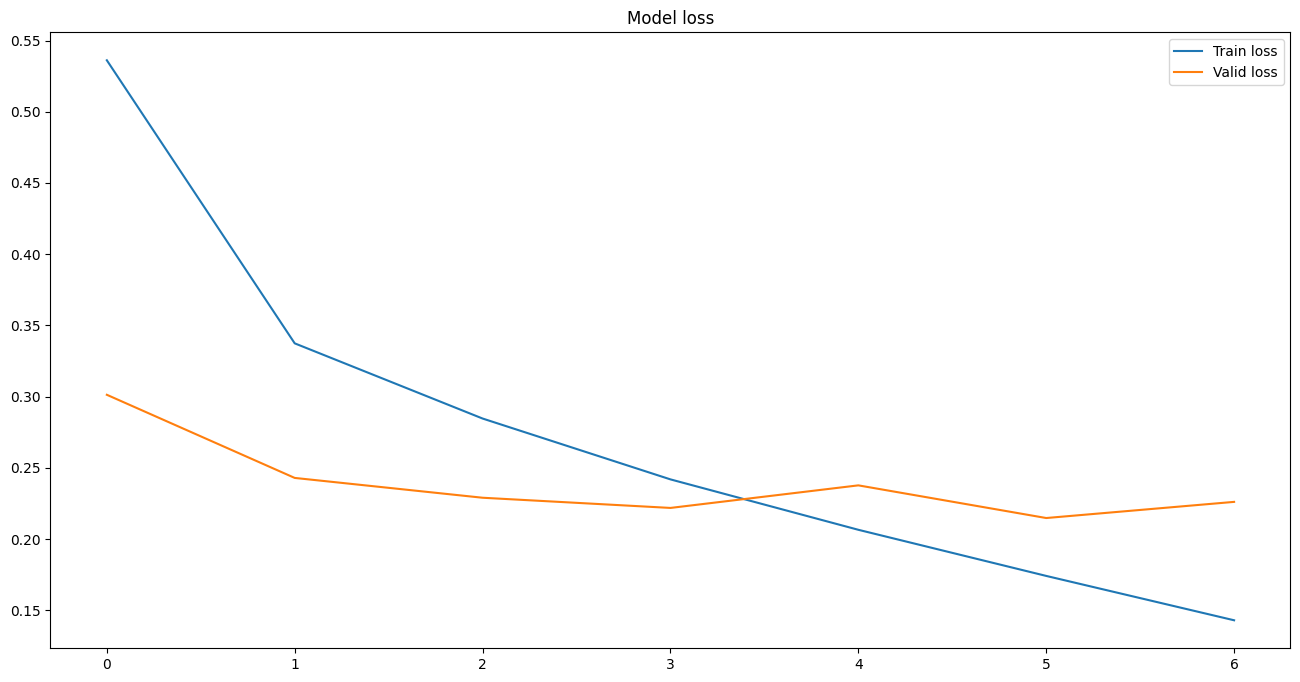

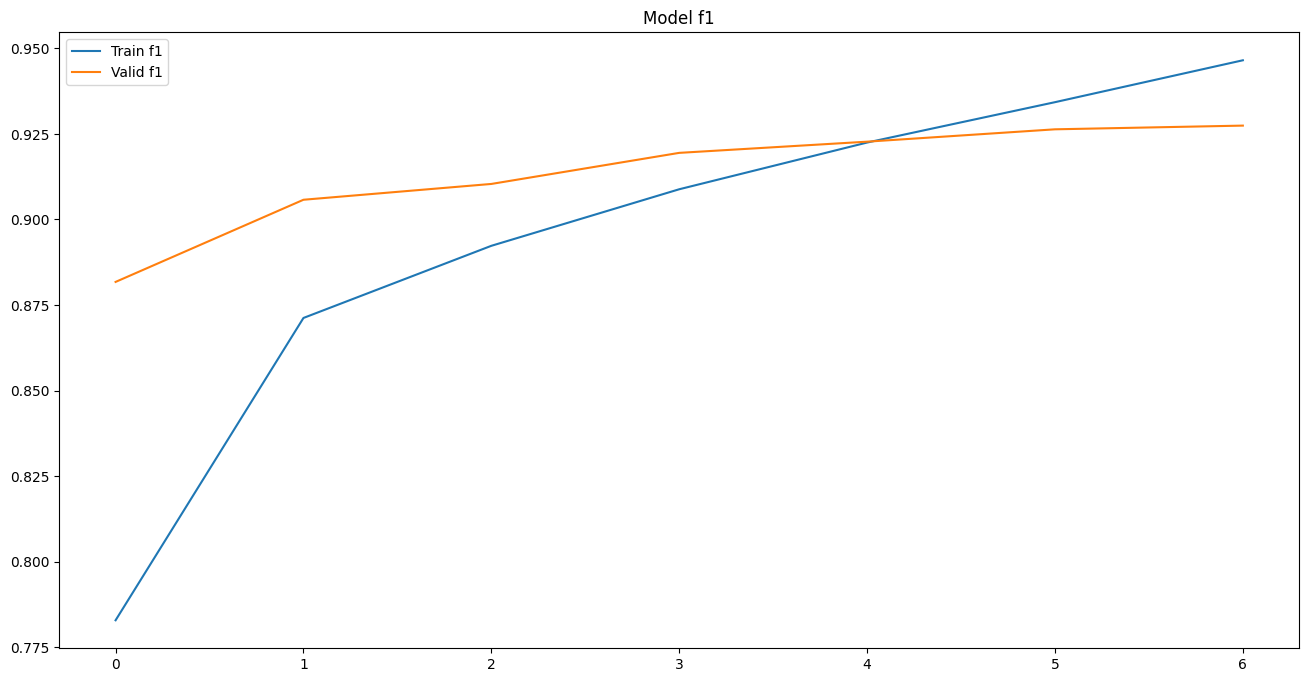

In [24]:
best_model, best_f1 = fit(model, trainloader, testloader, optimizer, loss_fn, 7)

In [25]:
# Установка модели в режим предсказания
best_model.eval()

# Перемещение модели на устройство, используемое для обучения
best_model = best_model.to("cuda")

## Тестирование

In [26]:
testdata = [x[0] for x in testset]

# Список предсказаний для тестирования
y_pred = []

# Итерация по каждой картинке в списке testdata
for image_tensor in tqdm(testdata):
    # Перемещение изображения на устройство, используемое для обучения
    image_tensor = image_tensor.to("cuda")

    # Прямое прохождение изображения через модель
    with torch.no_grad():
        output = best_model(image_tensor.unsqueeze(0))
    
    # Получение индекса класса с наибольшей вероятностью
    predicted_class = torch.argmax(output, dim=1).item()
    y_pred.append(predicted_class)

100%|██████████| 5401/5401 [00:12<00:00, 428.10it/s]


In [27]:
y_true = [x[1] for x in testset]

print(f"f1_score: {f1_score(y_true, y_pred, average='macro'):.4f}")

f1_score: 0.9274


In [29]:
df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
df.query("y_true != y_pred").y_true.value_counts(normalize=True)

y_true
2    0.505208
0    0.369792
1    0.125000
Name: proportion, dtype: float64